# Exploring the Data Space of the Space Data Explorers

_In this notebook we will use the Twitter API to explore the conversation happening on Twitter related to NASA and Space Apps. We will be looking at a collection of tweets from recorded esporadically between Thursday night (before the first all-women spacewalk!) till now._

Questions we'll try to answer:

1) *What is the sentiment of the conversation?*

2) *What's the conversation about? *

3) *Can we build a few profiles based on information provided by users in their description?*

4) *Where (in the physical world) are people tweeting from and of those locations which ones have a higher engagement?*

##### You can find the code at https://github.com/nelabdiel/EtDSofSDE

In [1]:
import pandas as pd
import scipy as sp
import random as rdm
import requests  # better than the urllib libraries
import simplejson
from requests_oauthlib import OAuth1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords 
from textblob import TextBlob
import heapq
from collections import Counter
from wordcloud import WordCloud
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from itertools import islice, chain
from IPython.display import Image
from IPython import display
import matplotlib.pylab as plt
%matplotlib inline
import pysal as ps
from pysal.contrib.viz import mapping as maps
from pylab import *

from pylab import rcParams
rcParams['figure.figsize'] = 12, 7

import sys
from twython import Twython
import os
from datetime import datetime


import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### We need twitter credentials in order to use the API. For more info on how to obtain them go to https://developer.twitter.com/en/docs

In [3]:
with open("../twitter_secrets2.json.nogit") as fh:
    secrets = simplejson.loads(fh.read())


auth = OAuth1(
    secrets["api_key"],
    secrets["api_secret"],
    secrets["access_token"],
    secrets["access_token_secret"]
)

# Let's create a function to request the posts we are interested in.

In [754]:
#L = []

def tweet_generator():
    """ Generator that live streams tweets (see 'yield' keyword)"""
    stream = requests.post('https://stream.twitter.com/1.1/statuses/filter.json',
                           auth=auth, 
                           stream=True,
                           data={"track":["nasa", 
                                          "@nasa",
                                          "#nasa",
                                          "#spaceappschallenge", 
                                          "space apps",
                                          "#spaceapps",
                                          "@spaceapps",
                                          "@spaceappsCLE",
                                          "#space"
                                         ]#, 
                                 #"languages":"en"#
                                })
    
    for line in stream.iter_lines():
        if not line:  # filter out keep-alive new lines
            continue
        tweet = simplejson.loads(line)
        if ('text' in tweet):
            L.append(tweet)
            yield tweet['text']

### Let's use that function to get a 1000 tweets!

In [819]:
c = 0
for tweet in islice(tweet_generator(), 1000):
    c += 1
    if c % 100 == 0:
        print('\n')
        print(c)
        print('\n')
    print(tweet)

RT @ezralevant: Omigod stop lying. NASA didn't even recruit astronauts until you were twelve.

This is like when you said you were named af…
RT @AJA_Cortes: @HillaryClinton You were born in 1947, NASA wasn't formed until 1958 and we didn't have an astronaut in space until until 1…
RT @tracybeanz: Where’s the letter? https://t.co/fvketiE4Uu
RT @cicilavraie: trop drôle les mecs en commentaires qui ironisent sur la vaisselle &amp; le ménage alors qu'à 25 ans ils savent pas laver leur…
RT @matisidro: Brilliant to see science, space &amp; gender equality make the front pages of major newspapers! 

#space #equality #WomenInSTEM…
Top kek. NASA rektd Hillary.
RT @clairecmc: Why is she at this table? Get your kids out of the White House while they are “earning” 80+ million last year. And until you…
@NASAHubble ⭐ @isro @NASA @FreemanDys0n . @taylorswift13
RT @C_3C_3: There’s a higher probability that Corn Pop is real than young Hillary Clinton writing a letter to NASA.

She’s a pathological l…
@

With the advent of ADMITTED bold face fake news by the MSM.  Psychopaths will try as well if anyone will listen...
@RaissaLima_Reis foi feita pela NASA essa merda kkkkk
https://t.co/gB88b2q1PY| @KarolGmusic visitó la #NASA y así lo registró, ¿Irá a la luna?
👇
https://t.co/FoO8NbBGg7 https://t.co/hZJBHjP0Jc
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the…
@HillaryClinton Is that like that time you falsely accused the Marine Corps of not wanting to allow a Yale educated… https://t.co/VEjDSeJI11
RT @songbirdtweets1: Kungbaga sa Theme Park ito yung pinaka ExtremeRollerCoasterRide. Grabe yung intensity sa taas sabay swabeng transition…
RT @CecaPereca26: Ovo je nas ponos, nasa vojska. I sto jaca vojska, jaca drzava. Cestitke za Dan oslobodjenja. https://t.co/xqyQRmb5zn
RT @tkunsman: Our special Saturday key note @spaceappsCLE @SpaceApps #SpaceAppsCLE @NASAglenn https://t.co/r4P4oUBqNM
RT @cicilavraie:

RT @viewsfrance: Aujourd’hui, et après 50 ans de sorties spatiales masculines, la NASA s’apprête à réaliser pour la 1ère fois une sortie sp…
RT @SB19Official: Sobrang thankful po kami sa lahat ng nagpunta sa SM City BF Parañaque! Para kaming nasa sky dahil may blue kahit saan 💙 D…
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the…
@Chip2chip2 @kulotissima 😳bakit ka nagWendy? wala bang in n out bordyer dyan, mas masarap.
nasa Pampanga ka pala ng… https://t.co/Mh6CCCrnCP
RT @milcaricaturas: HISTÓRICA CAMINATA ESPACIAL...
#AllWomenSpacewalk 
@NASA https://t.co/CeBHVdSXYV
RT @ezralevant: Omigod stop lying. NASA didn't even recruit astronauts until you were twelve.

This is like when you said you were named af…
RT @elfamosopaulo: https://t.co/ItalP5SAZN https://t.co/OTsU5S51oJ
A nasa tem que estudar esse ser lkkkkkkkkkkkkkkk
@JimBridenstine @SpaceX @NASA Sure you are!
RT @Easycure: You were born in 194

@ebishopphoto @myrubypearl @Tentoads4truth @carrybeyond @ThomasS4217 @DKnight10000 It looks as though he may be on… https://t.co/StzSrWRrzO
RT @ezralevant: Omigod stop lying. NASA didn't even recruit astronauts until you were twelve.

This is like when you said you were named af…
RT @viewsfrance: Aujourd’hui, et après 50 ans de sorties spatiales masculines, la NASA s’apprête à réaliser pour la 1ère fois une sortie sp…
RT @mrmanhere_: Deeper into my what? https://t.co/JFS00BqYgm
RT @DrakeGatsby: [Tour of NASA Headquarters] 

Guide: So NASA was founded in July of 1958 with the goal- 

Me: *interrupting* Is it true th…
RT @MartinMillnert: Presentation of the NASA Ames Icebreaker mission proposal by Carol Stoker at the #MarsSocCon2019 (h/t @We_Martians ) ht…
@NASA @POTUS @Astro_Christina @Astro_Jessica @Space_Station They should have said, we found a new leader up here
@carin__fischer https://t.co/EF3pprhX0a
What do you think about this book?

Serbian &amp; English
@elonmusk @SpaceX @s1com

RT @KamalaHarris: For the first time in our nation’s history, an all-female crew walked in space today. It’s more than historic—it’s a remi…
RT @hubo_at_hubad: 🔞 #chupainmoko pamangkin ko. sarap magpachupa at kumantot, 20th birthday pa nya. Sunday ng hapon, nagsimba ang mga nasa…
RT @nevsinmengu: Kocasına kahvaltı hazırlamak varken uzaya çıkmış cıkcıkcık https://t.co/CSTkOiRuxh
gwapo ng nasa heAder ko kbye
RT @Sophiekatchu: @julialicious3 @godgaxxi https://t.co/z3WHljmyNo basahin mo lahat yung nasa article... sobrang bait nung sumulat ng lette…
RT @d1KilalaMo: talagang ang pangarap ay wala sa edad, nasa pagpupursige.. #MMKTheYamyamStory
Gustoo ko talagaaa yung nasa header kooo!!!☹️💗
Oh, hey 👋 
#SpaceApps #DataScience
@freesubwaywifi @eleonore_keith @bhherring @NASA @AlyndertheRed1 @BryanMooreGroup @keane721 @KathyinKenya… https://t.co/6NkoFMnRcx
RT @fabbrdn: Mdrrr y’a autant de poussière que sa sur la Lune ? https://t.co/OwcLlnZOZF
RT @cicilavraie: trop drôle les mecs en commentaires q

RT @TorCWoman: So are the climate change hoaxers denting real science in order to fear monger?

These people have been fear mongering for l…
@starkleus yung 10.9.8 ata yung product nun ididivide mo sa product nung nasa parenthesis??
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the…
It was the first time in more than half a century of space exploration that two women walked in space together. 
https://t.co/kbTxaju0o4
RT @ezralevant: Omigod stop lying. NASA didn't even recruit astronauts until you were twelve.

This is like when you said you were named af…
RT @reisanapaulaf: queria estar no nasa space
RT @ezralevant: Omigod stop lying. NASA didn't even recruit astronauts until you were twelve.

This is like when you said you were named af…
Tahimik lang daw ako pero nasa loob daw ang kulo ko,kinginaaaaa kilala nyo ba talaga ako?
RT @KVeusebio: Congrats pa din Lady Lions I love you all tandaan niyo d

RT @GeekGirlsLatam: Hoy en la estación espacial de la @NASA 4 talentosas mujeres realizan labores importantes importantes de ingeniería y c…
RT @griey_: ang hirap ng bobo, di maprocess agad ng utak ko yung mga nasa libro, kaya i always have to write every damn shit tapos saka ko…
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the…
RT @Homesdenegre: Advertencia de la NASA: Un asteroide de un kilómetro de diámetro se acercará a la Tierra el 25 de octubre https://t.co/9P…
RT @NASA: Throughout spaceflight history, 14 women have completed spacewalks. Today, @Astro_Jessica brought that number up to 15 as she flo…
RT @ECMcLaughlin: Scroll to 2:00 minutes and watch what happens.

Because, you know, the President flipping off a female astronaut in space…
RT @nevsinmengu: Kocasına kahvaltı hazırlamak varken uzaya çıkmış cıkcıkcık https://t.co/CSTkOiRuxh
RT @ValerieJarrett: Little girls growing up today will 

Ano man ang hiling, aking susundin. Ang nasa loob, ipagkakaloob. Ngayon din, NOW NA!!!!
halatang di ako marunong ng kahit ano tungkol sa mga LS anywayz NEXT! AYON MAY SUMMER NIGHTS ALBUM NA AKO TAS SYMPR… https://t.co/MQn1Q31zkT
RT @dbongino: Did you accuse them of being “Russian assets” afterwards? https://t.co/6dw6cddvij
#NASA are LIARS! 100% #FLATEARTH PROOF HERE: https://t.co/l8SpsYYJVB Saturday October 19 2019:1:24:57 PM
RT @gagana_gaga: @VucevicM Deca su nase najvece bogatstvo i nasa budućnost. Za njih i treba graditi sve najsavremenije.
gusto ko mag NASA pero yung score ko sa science mababa lang, ewan ko lang sa math.
RT @Guy_Golo: - Vous ne prenez que le strict minimum hein ?
- Oui oui !
https://t.co/01NKCuMdDi https://t.co/ISAYgOxdjA
RT @WendyMeer11: “And then there was the fact of a woman’s traveling alone to Belize “by herself for only three days, including travel. Not…
NASA is developing a Shapeshifting Robots for Saturn’s Moons https://t.co/f0XF51tlbS https://t.co/MxrLT5JS

RT @dbongino: Did you accuse them of being “Russian assets” afterwards? https://t.co/6dw6cddvij
RT @pmbasse: @HillaryClinton What happened to being so "gusty"? You not so brave are you crooked lying Hillary.. You afraid to face Tulsi?…
RT @cmclymer: The first NASA mission that directly passes the Bechdel test. I'm here for it.

#AllWomanSpacewalk
RT @Cmdr_Hadfield: On a clear day on Mars, you can see our robots from orbit. 

(that's @NASAInSight, taken from the Mars Reconnaissance Or…
RT @Alias255k: - Houston on a un problème 
- Oui dites nous ?
- Rien laisse tomber. 
- mais ? 
- Bonne nuit. https://t.co/mbtk4kE9G5
RT @NASA: Throughout spaceflight history, 14 women have completed spacewalks. Today, @Astro_Jessica brought that number up to 15 as she flo…
RT @cicilavraie: trop drôle les mecs en commentaires qui ironisent sur la vaisselle &amp; le ménage alors qu'à 25 ans ils savent pas laver leur…
RT @MengsheeDeiko: @krizgazmen @analizadd #IsaFeelGoodWeekend with family ang mga nasa cine

Nasa 100k tuition ng nursing sa Tytana isang sem tapos di ka mag-aaral?????
@NASA @POTUS @Astro_Christina @Astro_Jessica In the news today: women are so over it all we have decided to leave the planet
RT @8nja: Otra vez se le pasaron los cocteles a la abuela. 

https://t.co/mthtjRRZTZ https://t.co/vQE8rQqlaY
RT @KamalaHarris: For the first time in our nation’s history, an all-female crew walked in space today. It’s more than historic—it’s a remi…
RT @KiaraGino2019: my gosh cassieee! sana oillll ! kung nasa davao lang ako ! ahuhuhu enjoy kayo love birds !

BoomBirthdayNaNi GinoRoque h…
Tapos isusulat pa namin yung lahat ng nasa ppt (na galing sa slideshare) eh 88 slides yun, nasa 19 palang ako🤦‍♀ an… https://t.co/aV0EDA96MJ
RT @cicilavraie: trop drôle les mecs en commentaires qui ironisent sur la vaisselle &amp; le ménage alors qu'à 25 ans ils savent pas laver leur…
#Apple previews For All Mankind at New York Comic Con, pitched as ‘Mad Men for NASA’
https://t.co/Kz6S7fwx4b
RT @MOOSA_PAT

RT @mikebravodude: Ladies and Gentlemen I give you #QueenOfWarmongers. 

Born 1947 talking about writing a letter as a little girl to NASA,…
RT @WhiteHouse: "Please stand by for a call from the President of the United States." 

Congratulations to @NASA astronauts @Astro_Christin…
RT @WomenNASA: Today, @NASA_Astronauts and best friends @Astro_Christina and @Astro_Jessica embarked on the very first #AllWomanSpacewalk o…
RT @WrathOfKhan2016: Congrats to Christina Koch and Jessica Meir on the first-ever all-female spacewalk.  Since @realDonaldTrump is so inte…
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the…


700


RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the…
RT @padillacathh: “Iba talaga glow up pag nasa tamang tao ka”

NOPE. IBA GLOW UP MO PAG MASAYA KA SA BUHAY MO , NATUTUNAN MO MAHALIN SARILI…
Pero 

RT @SPACEdotcom: The 1st Human on Mars May Be a Woman, NASA Chief Says https://t.co/28h0JI6lEO https://t.co/LhInOWu0yR
RT @ezralevant: Omigod stop lying. NASA didn't even recruit astronauts until you were twelve.

This is like when you said you were named af…
RT @ValerieJarrett: Little girls growing up today will think this historic event is perfectly normal.  #AllWomanSpacewalk . https://t.co/qp…
RT @DJLOK: And may @NASA find a way to quickly fulfill 👇👇👇 her dreams before she accuses another person of being a #RussianAsset. https://t…
@SchmaltzMichael @HillaryClinton Yeah nasa was founded when she was 11. Lmao
@sweetheartcsy @MelodyItsOk Pinapasok niya sa bahay iyong nasa left gulat sha nakita niya sa kwarto mo iyong nasa r… https://t.co/9Y7YXKqJ22
RT @NASA: “You’re doing an incredible job,” says @POTUS to @Astro_Christina and @Astro_Jessica during today’s #AllWomanSpacewalk. Tune in t…
RT @tracybeanz: Where’s the letter? https://t.co/fvketiE4Uu
THANK YOU !
And I loved everything abou

RT @MaichardArmy: ALAM NIYO NG NEGA AT IKAKASAMA NG LOOB NIYO DUN PA KAYO NAKABABAD. KATANGAHAN NA PO IYAN, ANG UTAK NASA TAAS.

BASTA ANG…
RT @dan_pizzo: To my 3 daughters....THIS!! https://t.co/CypUN3Vcfj
RT @SB19Official: Sobrang thankful po kami sa lahat ng nagpunta sa SM City BF Parañaque! Para kaming nasa sky dahil may blue kahit saan 💙 D…
RT @cicilavraie: trop drôle les mecs en commentaires qui ironisent sur la vaisselle &amp; le ménage alors qu'à 25 ans ils savent pas laver leur…
RT @HillaryClinton: When I was a little girl, I wrote to NASA and told them I dreamed of being an astronaut. 

They wrote back and said the…
RT @C_3C_3: There’s a higher probability that Corn Pop is real than young Hillary Clinton writing a letter to NASA.

She’s a pathological l…
RT @NASA: During our #AllWomanSpacewalk, there was an Earth-to-space call as @POTUS called @Astro_Christina &amp; @Astro_Jessica to congratulat…
RT @NASA: Throughout spaceflight history, 14 women have completed spacewalks. To

RT @cicilavraie: trop drôle les mecs en commentaires qui ironisent sur la vaisselle &amp; le ménage alors qu'à 25 ans ils savent pas laver leur…
RT @glennlibrary: @spaceappsCLE @SpaceApps @NASAglenn Excited to hear all about our lunchtime keynote speaker! We're getting into the data…
RT @dbongino: Did you accuse them of being “Russian assets” afterwards? https://t.co/6dw6cddvij
Oh give it a rest. President Obama used that middle finger to rub the side of his nose when getting a question he d… https://t.co/j8cBBLE9yL
@Roxanne05042140 @Elizabe44166685 @HillaryClinton She was 11 when NASA was founded. Lmao she’s lying.
@ufoartwork Lol. Bigelow helped put this TTSA thing together. He’s already been working with NASA for years. Hell,… https://t.co/lg1fH7Ocow
RT @SPACEdotcom: The 1st Human on Mars May Be a Woman, NASA Chief Says https://t.co/28h0JI6lEO https://t.co/LhInOWu0yR
RT @WhipClyburn: Congratulations to NASA astronauts Jessica Meir and Christina Koch on completing the first-ever all-

KeyboardInterrupt: 

### What data is there?

In [820]:
L[0]

{'created_at': 'Thu Oct 17 21:07:09 +0000 2019',
 'id': 1184938925703319552,
 'id_str': '1184938925703319552',
 'text': 'RT @riahfab: Ikaw na nasa bus/jeep na antok na antok na tapos sumakay si crush https://t.co/xEQcsLnUnH',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1002518687813754880,
  'id_str': '1002518687813754880',
  'name': 'amme',
  'screen_name': 'rhaeex',
  'location': "Jc's ❤🏳️\u200d🌈",
  'url': None,
  'description': 'Have Faith, Hope and Love 😇💕 || Astrophile ✨',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 342,
  'friends_count': 520,
  'listed_count': 0,
  'favourites_count': 19843,
  'statuses_count': 11750,
  'created_at': 'Fri Jun 01 11:54:15 +0000 2018',
  'utc_offs

### Lets now extract some information from each tweet and save it in a dataframe.

In [821]:
df = pd.DataFrame()

In [822]:
k = 0
for el in L:
    try:
        temp = pd.DataFrame([[el['text'], el['lang'], 
                              el['coordinates'], el['place'],
                              el['timestamp_ms'], 
                              el['created_at'], el['user']['location'], 
                              el['user']['description'], 
                              el['user']['screen_name'],
                              el
                             ]
                            ], 

                            columns=['text', 'lang', 
                                     'location', 'place',
                                     'timestamp',
                                     'created_at', 'user_location', 
                                     'user_description','screen_name', 
                                     'raw_data'])
        df = df.append(temp, ignore_index=True, sort=True)
    except:
        pass
df.tail()

created_at lang location place  \
22936  Sat Oct 19 16:35:29 +0000 2019   es     None  None   
22937  Sat Oct 19 16:35:29 +0000 2019   tl     None  None   
22938  Sat Oct 19 16:35:30 +0000 2019   en     None  None   
22939  Sat Oct 19 16:35:30 +0000 2019   tl     None  None   
22940  Sat Oct 19 16:35:31 +0000 2019   es     None  None   

                                                raw_data      screen_name  \
22936  {'created_at': 'Sat Oct 19 16:35:29 +0000 2019...  unaestupidadice   
22937  {'created_at': 'Sat Oct 19 16:35:29 +0000 2019...     Itsmedimple7   
22938  {'created_at': 'Sat Oct 19 16:35:30 +0000 2019...      BlackIrishI   
22939  {'created_at': 'Sat Oct 19 16:35:30 +0000 2019...  gisilgslgiselle   
22940  {'created_at': 'Sat Oct 19 16:35:31 +0000 2019...     ItsJustCutie   

                                                    text      timestamp  \
22936  RT @ReaIJhonathan: Peo el México\nPeo en Argen...  1571502929525   
22937  RT @SB19Official: Sobrang thankful po kami sa ...  1571502929980   
22938  RT @Easycure: You were born in 1947, NASA wasn...  1571502930104   
22939  Ang hirap naman nun, nasa Concert ako ng GOT7 ...  1571502930879   
22940              Hoy nasa venezuela na si samantha lo!  1571502931002   

                                        user_description  \
22936                                               None   
22937                                            SB19💕💕💕   
22938  Adore my children. Love animals. Former Air Fo...   
22939             BTS ARMY 💜 OT7 STAN | COOKY x KOOKIE 🐰   
22940  1.Joshua Garcia (Ph) \n2.Guo Junchen (Cn) \n3....   

               user_location  
22936                   None  
22937                   None  
22938  Colo. (God's Country)  
22939                  PH 🇵🇭  
22940            Philippines

In [814]:
df.shape

(18998, 10)

### Let try to answer question (1): What is the sentiment of the conversation?

In [557]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

def get_tweet_sentiment(tweet): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(clean_tweet(tweet)) 
    # set sentiment 
    return analysis.sentiment.polarity

### Lets score the sentiment on our tweets

In [823]:
df['sentiment'] = df.apply(lambda x: get_tweet_sentiment(x['text']), 1)

In [824]:
# What is the average sentiment?

In [825]:
df['sentiment'].mean()

0.06016106545503288

In [826]:
# What is the average sentiment of tweets containing the word 'nasa'

In [827]:
df[df['text'].str.contains('nasa')]['sentiment'].mean()

0.04851678575020321

In [828]:
# What is the average sentiment of tweets containing 'spaceapps' or 'space app'

In [829]:
df[(df['text'].str.contains('spaceapps')) | (df['text'].str.contains('space app'))]['sentiment'].mean()

0.08495928674500104

In [830]:
# Let's take a look at the ones containing 'spaceapps' or 'space app'

In [831]:
df[(df['text'].str.contains('spaceapps')) | (df['text'].str.contains('space app'))]

created_at lang  \
339    Thu Oct 17 21:12:04 +0000 2019   en   
1629   Thu Oct 17 23:19:50 +0000 2019   en   
1813   Thu Oct 17 23:23:30 +0000 2019   en   
3306   Fri Oct 18 10:42:24 +0000 2019   en   
5485   Fri Oct 18 18:57:51 +0000 2019   en   
5938   Fri Oct 18 19:00:22 +0000 2019   en   
6145   Fri Oct 18 19:31:29 +0000 2019   en   
6728   Fri Oct 18 19:34:29 +0000 2019   en   
6732   Fri Oct 18 19:34:31 +0000 2019   es   
6857   Fri Oct 18 19:35:06 +0000 2019   es   
6882   Fri Oct 18 19:35:11 +0000 2019   es   
7025   Fri Oct 18 19:35:55 +0000 2019   en   
7218   Fri Oct 18 19:36:59 +0000 2019   es   
7666   Fri Oct 18 19:39:22 +0000 2019   en   
8754   Fri Oct 18 21:49:43 +0000 2019   en   
9754   Sat Oct 19 02:05:03 +0000 2019   en   
10744  Sat Oct 19 10:23:59 +0000 2019   en   
11145  Sat Oct 19 10:42:16 +0000 2019   es   
11409  Sat Oct 19 10:44:05 +0000 2019   es   
11707  Sat Oct 19 10:46:03 +0000 2019   es   
11746  Sat Oct 19 10:46:16 +0000 2019   en   
12016  Sat Oct 19 12:43:27 +0000 2019   es   
12019  Sat Oct 19 12:43:28 +0000 2019   pt   
12144  Sat Oct 19 12:44:18 +0000 2019   en   
12346  Sat Oct 19 12:45:24 +0000 2019   en   
12594  Sat Oct 19 12:46:53 +0000 2019   ca   
12714  Sat Oct 19 12:47:33 +0000 2019  und   
12784  Sat Oct 19 12:48:00 +0000 2019   pt   
12843  Sat Oct 19 12:48:21 +0000 2019   es   
12865  Sat Oct 19 12:48:27 +0000 2019   en   
...                               ...  ...   
14191  Sat Oct 19 13:50:11 +0000 2019   es   
14242  Sat Oct 19 13:50:31 +0000 2019   en   
14746  Sat Oct 19 13:53:16 +0000 2019   en   
15149  Sat Oct 19 14:38:49 +0000 2019   ja   
15168  Sat Oct 19 14:38:54 +0000 2019   ja   
15186  Sat Oct 19 14:38:59 +0000 2019   ja   
15266  Sat Oct 19 14:39:20 +0000 2019   ja   
15589  Sat Oct 19 14:40:58 +0000 2019   ja   
16490  Sat Oct 19 15:07:17 +0000 2019   ca   
16553  Sat Oct 19 15:07:39 +0000 2019   es   
16995  Sat Oct 19 15:10:05 +0000 2019   en   
17041  Sat Oct 19 15:10:21 +0000 2019   es   
18329  Sat Oct 19 15:17:09 +0000 2019   en   
18590  Sat Oct 19 15:18:31 +0000 2019   en   
19009  Sat Oct 19 15:37:51 +0000 2019   en   
19177  Sat Oct 19 15:38:40 +0000 2019   en   
19211  Sat Oct 19 15:38:53 +0000 2019   en   
19395  Sat Oct 19 15:40:01 +0000 2019   es   
20090  Sat Oct 19 15:44:11 +0000 2019   es   
20847  Sat Oct 19 15:48:30 +0000 2019  und   
21829  Sat Oct 19 15:54:21 +0000 2019   es   
21903  Sat Oct 19 15:54:50 +0000 2019   en   
21971  Sat Oct 19 15:55:10 +0000 2019   es   
22058  Sat Oct 19 16:30:14 +0000 2019   en   
22072  Sat Oct 19 16:30:22 +0000 2019   en   
22078  Sat Oct 19 16:30:25 +0000 2019   en   
22357  Sat Oct 19 16:32:03 +0000 2019   en   
22778  Sat Oct 19 16:34:34 +0000 2019   en   
22902  Sat Oct 19 16:35:15 +0000 2019   en   
22916  Sat Oct 19 16:35:21 +0000 2019   en   

                                                location  \
339                                                 None   
1629                                                None   
1813                                                None   
3306                                                None   
5485                                                None   
5938                                                None   
6145                                                None   
6728                                                None   
6732                                                None   
6857                                                None   
6882                                                None   
7025                                                None   
7218                                                None   
7666                                                None   
8754                                                None   
9754                                                None   
10744                                               None   
11145                                               None   
11409                             

### Let's graph the sentiment!

In [832]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [833]:
dfS = df[['created_at', 'sentiment']].groupby('created_at')['sentiment'].mean().reset_index()
#dfS['color'] = dfS.apply(lambda x: 'g' if x['sentiment'] >= 0 else 'r', 1)
dfS.head()

created_at  sentiment
0 2019-10-17 21:07:09   0.068182
1 2019-10-17 21:07:10   0.000000
2 2019-10-17 21:07:11   0.325000
3 2019-10-17 21:07:12   0.000000
4 2019-10-17 21:07:13   0.068182

In [834]:
dfS = dfS.set_index('created_at')
dfS.tail()

sentiment
created_at                    
2019-10-19 16:35:26   0.000000
2019-10-19 16:35:28   0.616667
2019-10-19 16:35:29   0.050000
2019-10-19 16:35:30   0.000000
2019-10-19 16:35:31   0.000000

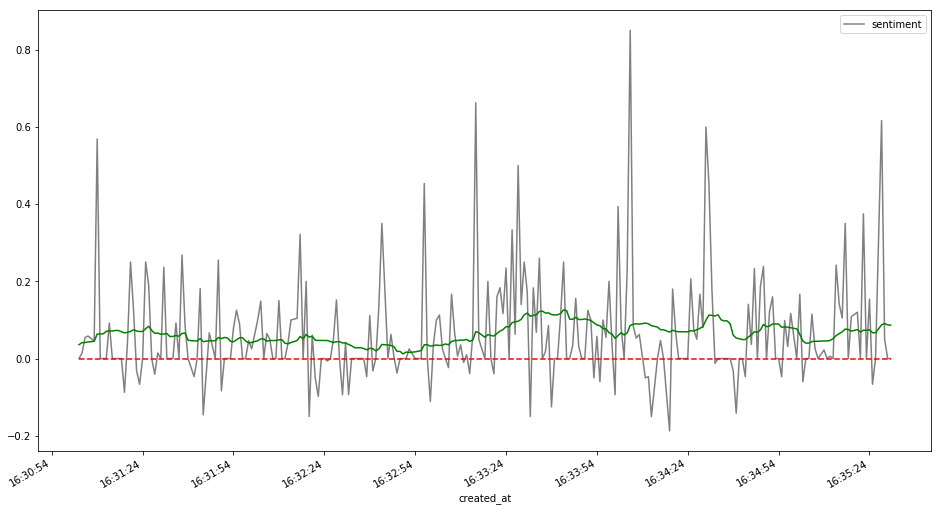

In [835]:
rcParams['figure.figsize'] = 16, 9

dfS[-250:].plot(kind='line', color='grey')

ax1 = dfS['sentiment'].rolling(30, min_periods=1).mean()[-250:].plot(kind='line', color='g')
plt.plot(dfS.index[-250:], [0]*len(dfS.index[-250:]), '--r')

## Let's try to answer question (2) now. What's the converation about?

In [771]:
stop = set(stopwords.words('english'))  # predefined list of "uninteresting" words

counter = Counter()

def nlargest(n, word_scores):
    """ Wrapper around heapq to return the n words with the largest count."""
    # word_scores: index 0=>word, 1=>count
    return heapq.nlargest(n, word_scores, key=lambda x: x[1])

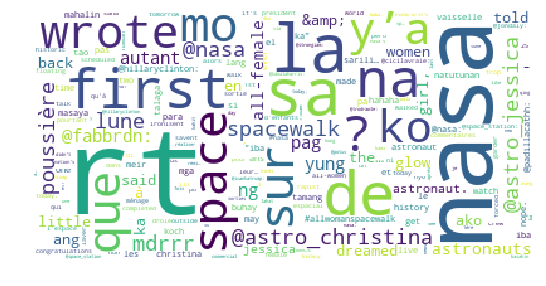

In [836]:
rcParams['figure.figsize'] = 9, 6
DISPLAY_EVERY = 100

try:
    for k in range(len(L)):
        try:
            tweet = L[k]['text']
            for word in tweet.lower().split():
                if word not in stop and 'http' not in word:
                    counter[word] += 1
            if k % DISPLAY_EVERY == (DISPLAY_EVERY - 1):
                wordcloud = WordCloud(background_color='white'#, collocations=False #, 
                                      #width=1600, height=800
                                     ).fit_words(counter)
                plt.axis("off")
                display.clear_output(wait=True)
                plt.imshow(wordcloud)
                display.display(plt.gcf())
        except:
            pass
    display.clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [773]:
nlargest(10, counter.items())

[('rt', 10998),
 ('nasa', 6293),
 ('la', 2468),
 ('sa', 2388),
 ('de', 2257),
 ('first', 1887),
 ('na', 1585),
 ('?', 1351),
 ('mo', 1309),
 ('sur', 1281)]

In [774]:
#L = [x for x in L if x]

### Is there more than one topic?

In [775]:
#Collect only the tweets
T = []
for tweet in L:
    T.append(tweet['text'])

In [776]:
BATCH_SIZE = 100
CLUSTER_SIZE = 4

kmeans = MiniBatchKMeans(n_clusters=CLUSTER_SIZE)

def batch(iterable, size):
    """ batch("ABCDEFG", 3) -> ABC DEF G """
    sourceiter = iter(iterable)
    while True:
        batchiter = islice(sourceiter, size)
        yield chain([next(batchiter)], batchiter)

In [777]:
with open("dictnostops.txt") as fh:
    words = [line.strip() for line in fh.readlines()]
    word_to_index = { word: k for k, word in enumerate(words) }

In [778]:
def wordclouds(wordcounts):
    wordclouds = [WordCloud().fit_words(Counter({k:v for (k,v) in dict(counts).items() if v > 0})) for counts in wordcounts]
    fig, axes = plt.subplots(2,2)
    display.clear_output(wait=True)
    for k, (ax, wordcloud) in enumerate(zip(axes.flatten(), wordclouds)):
        ax.axis("off")
        ax.imshow(wordcloud)
        ax.set_title("Topic %d" % k)
    display.display(fig)
    fig.clear()

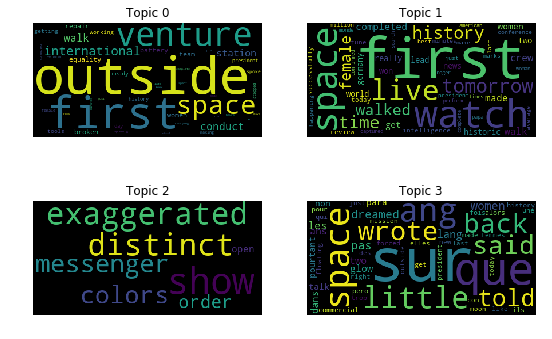

/Users/Nel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: generator 'batch' raised StopIteration
  from ipykernel import kernelapp as app


<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

In [780]:
try:
    for tweets in batch(T, BATCH_SIZE):
        mat = sp.sparse.dok_matrix((BATCH_SIZE, len(words)))
        for row, tweet in enumerate(tweets):
            for word in tweet.lower().split():
                if word in word_to_index:
                    mat[row, word_to_index[word]] = 1.
        kmeans.partial_fit(mat.tocsr())
        wordcounts = [nlargest(50, zip(words, kmeans.cluster_centers_[i])) for i in range(kmeans.n_clusters)]
        wordclouds(wordcounts)
except:
    pass

### Let's move on to question (3): Can we build a few profiles based on information provided by users in their description?

In [837]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['user_description'].dropna().drop_duplicates())

In [838]:
X.shape

(17042, 42408)

In [839]:
print(vectorizer.get_feature_names()[1000:1020])

['911survivor', '9189', '91b', '92', '9228', '92i', '93', '9333', '93歳の義母', '94', '945619', '9471', '94line', '95', '9558', '96', '97', '972', '97524', '9781432741488']


In [840]:
dfDBS = df['user_description'].dropna().drop_duplicates().reset_index()

In [841]:
clustering = DBSCAN(eps=.5, min_samples=3).fit(X)

In [842]:
dfDBS['dbscan'] = clustering.labels_

In [843]:
dfDBS['dbscan'].unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 37, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 28, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31,
       32, 33, 34, 35, 36])

In [844]:
dfDBS[dfDBS['dbscan'] == 1]

index user_description  dbscan
309      408           He/Him       1
12722  16917           He/him       1
12943  17196    [he/him] 🏳️‍🌈       1

In [845]:
for l in range(1,dfDBS['dbscan'].unique().max()):
    print('user names:')
    for q in list(dfDBS[dfDBS['dbscan'] == l]['user_description']):
        print(q)
    t = list(df.loc[list(dfDBS[dfDBS['dbscan'] == l]['index'])]['text'])
    print('\n')
    print('tweets:')
    for a in t:
        print(a)
    print('\n')
    print('\n')

user names:
He/Him
He/him
[he/him] 🏳️‍🌈


tweets:
RT @NASAInSight: ICYMI: The mole is on the move.
This video recaps our latest heat probe recovery efforts. We still have a long way to go.🤞…
RT @unabanned: The Soviets had a woman fly rocket two years later. Her name was Valentina Tereshkova and she became the first lady astronau…
RT @cicilavraie: trop drôle les mecs en commentaires qui ironisent sur la vaisselle &amp; le ménage alors qu'à 25 ans ils savent pas laver leur…




user names:
Manok Na Pula
MANOK NA PULA
manok na pula
Manok na pula


tweets:
RT @sayatttjaimeee: at
sinong
tanga
ang
nasa
twitter
kesa
nag-aaral
lt yung nasa instagram HAHAHAHAHA amp
RT @wantamad13: Pag nasa school:
"Panibagong araw panibagong katarantaduhan nanaman"
Pag nasa bahay:
"Panibagong araw panibagong hugas ng p…
Mahal ko nasa header q.




user names:
Happy
happy
Happy 😊


tweets:
RT @NASA: Even though they were designed for a two-year mission, our Van Allen Probes lasted for about seven years in one of

## Let's move on to my favorite part, geospatial analysis!! And let's try to answer question (4): Where (in the physical world) are people tweeting from and of those locations which ones have a higher engagement?

*We extracted the location information from the tweets that had it so let's see how many did.*

In [846]:
df.location.dropna()

1336     {'type': 'Point', 'coordinates': [112.72278627...
3457     {'type': 'Point', 'coordinates': [121.05386257...
6462     {'type': 'Point', 'coordinates': [-78.8962636,...
12594    {'type': 'Point', 'coordinates': [-0.33815361,...
17267    {'type': 'Point', 'coordinates': [-80.68148492...
17974    {'type': 'Point', 'coordinates': [-105.0250914...
20009    {'type': 'Point', 'coordinates': [-46.6333, -2...
21336    {'type': 'Point', 'coordinates': [-95.36283014...
22109    {'type': 'Point', 'coordinates': [-122.7756216...
Name: location, dtype: object

In [847]:
#df = df.drop(3350, axis=0)

## That's not very promising. What else can we do to get geospatial information? We can look into the 'place' key.

In [848]:
df.place.dropna()

248      {'id': '3b77caf94bfc81fe', 'url': 'https://api...
249      {'id': '0087ad0f1b6dfcc8', 'url': 'https://api...
267      {'id': '3b77caf94bfc81fe', 'url': 'https://api...
313      {'id': '01516da6022dca08', 'url': 'https://api...
321      {'id': '521b6f591c4b3ce8', 'url': 'https://api...
377      {'id': '006523c50dfe9086', 'url': 'https://api...
459      {'id': '01e93ed535e05b29', 'url': 'https://api...
485      {'id': '013379ee5729a5e6', 'url': 'https://api...
661      {'id': '07d9ec9cc0086001', 'url': 'https://api...
778      {'id': '3797791ff9c0e4c6', 'url': 'https://api...
868      {'id': '01d7c74272e5eafe', 'url': 'https://api...
961      {'id': '5579f6b17e36847b', 'url': 'https://api...
1012     {'id': '003d47f62835a9f1', 'url': 'https://api...
1063     {'id': '00fc4c873d8a5e32', 'url': 'https://api...
1094     {'id': 'd6819fe60643ebc1', 'url': 'https://api...
1117     {'id': '4ec01c9dbc693497', 'url': 'https://api...
1155     {'id': '0fa65e5e6fbf3eb8', 'url': 'https://api.

In [849]:
df.place.loc[248]

{'id': '3b77caf94bfc81fe',
 'url': 'https://api.twitter.com/1.1/geo/id/3b77caf94bfc81fe.json',
 'place_type': 'city',
 'name': 'Los Angeles',
 'full_name': 'Los Angeles, CA',
 'country_code': 'US',
 'country': 'United States',
 'bounding_box': {'type': 'Polygon',
  'coordinates': [[[-118.668404, 33.704538],
    [-118.668404, 34.337041],
    [-118.155409, 34.337041],
    [-118.155409, 33.704538]]]},
 'attributes': {}}

## Not all tweets have a 'place' key but there are definitely more of those than with a location. Inside 'place' there are coordinates for a geographical bounding box so let's compute its centroid and use that as a point of reference for location.

In [850]:
df1 = df[['place', 'text']].dropna().reset_index()
df1['centroid_lat'] = df1.apply(lambda x: np.array(x['place']['bounding_box']['coordinates'][0]).mean(axis=0)[0], 1)
df1['centroid_lon'] = df1.apply(lambda x: np.array(x['place']['bounding_box']['coordinates'][0]).mean(axis=0)[1], 1)

df1 = df1.groupby(['centroid_lat', 'centroid_lon'])['text'].count().reset_index()
df1.columns = ['centroid_lat', 'centroid_lon', 'count']

#### What are the most common centroids?

In [851]:
df1.sort_values(by='count', ascending=False)

centroid_lat  centroid_lon  count
156    121.062736     14.683012     11
147    120.983987     14.591457      7
85     -46.595546    -23.682803      4
94      -3.742541     37.791399      4
154    121.033212     14.546499      4
66     -77.014398     38.898603      3
165    121.124227     14.606718      3
52     -81.854561     41.419246      3
74     -73.968542     40.780709      3
8     -118.411907     34.020789      3
189    125.443261      7.317582      3
25     -95.446486     29.838495      3
46     -83.804475     27.698682      3
159    121.082345     14.583306      3
170    121.213935     14.155995      2
150    121.006950     14.532882      2
73     -74.243671      4.262283      2
42     -85.768241     37.822244      2
153    121.031142     14.710894      2
54     -81.197276     28.588445      2
140    120.962621     14.115378      2
47     -83.173867     32.678207      2
82     -61.811730     44.321234      2
6     -119.827182     39.512436      2
5     -122.330602     47.614817      2
113     34.968429     31.342253      2
101      0.131479     49.496210      2
95      -3.703508     40.477795      2
108     24.830963     65.862802      2
110     28.060613    -26.058708      1
..            ...           ...    ...
96      -3.203009     55.943196      1
1     -122.870030     44.847157      1
98      -1.630385     47.224783      1
99      -0.352529     39.422485      1
100     -0.338001     39.458730      1
102      0.314300     42.308346      1
103      5.974099     49.489683      1
80     -66.134334    -33.933572      1
78     -71.683502     42.036939      1
55     -80.737633     28.258804      1
64     -77.090869     38.817380      1
56     -80.650764     28.586010      1
57     -80.201097     44.080757      1
58     -79.861034     35.170499      1
59     -79.674847     44.371263      1
60     -79.428376     43.903509      1
61     -79.420865     38.003376      1
62     -79.272570     43.629311      1
63     -78.855078     35.723200      1
65     -77.079619     39.090427      1
77     -72.455370     41.297423      1
67     -75.770041     42.746617      1
68     -75.699457     39.736777      1
69     -75.483936     40.591825      1
70     -74.814403     10.839213      1
71     -74.315005     40.569527      1
72     -74.278855     40.266520      1
75     -73.948775     40.655138      1
76     -73.789133      5.108820      1
194    153.369361    -27.954221      1

[195 rows x 3 columns]

### Where are users located according to their bios?

In [852]:
df.groupby('user_location')['text'].count().sort_values(ascending=False).reset_index()

user_location  text
0                           Republic of the Philippines   349
1                                         United States   331
2                                                France   117
3                                                   USA   107
4                                         Paris, France   100
5                                       California, USA    93
6                                       Los Angeles, CA    88
7                                            Texas, USA    75
8                                           Philippines    73
9                                          Florida, USA    66
10                                         New York, NY    64
11                                                   🇵🇭    61
12                                       Washington, DC    59
13                                      London, England    52
14                                Ile-de-France, France    51
15                                               Canada    49
16                                                Earth    48
17                          Comunidad de Madrid, España    40
18                                          Chicago, IL    40
19                                          Houston, TX    40
20                                                India    39
21                                  North Carolina, USA    35
22                                        Lille, France    33
23                                        New York, USA    33
24                                            Worldwide    33
25                                                Paris    31
26                                            Australia    29
27                                         Lyon, France    29
28                                    Pennsylvania, USA    28
29                                     Toronto, Ontario    28
...                                                 ...   ...
8243                              Sukkur,Sindh,Pakistan     1
8244                                        Suffolk, VA     1
8245                                  Sta.Maria Bulacan     1
8246                                        Suffolk, UK     1
8247                      Standard Hotel, W. Hollyweird     1
8248                                Standing behind you     1
8249                                       Stanford, CA     1
8250                       Starnberg DE / New York City     1
8251                               State of Dismay, USA     1
8252                                          Stateless     1
8253                                   Stavropol.Russia     1
8254                                       Sterling, IL     1
8255                                          Stockholm     1
8256                                 Stockholm, Sverige     1
8257                                Stockholm, Sweden 🌍     1
8258                                 Stockport, England     1
8259                                       Stockton, CA     1
8260                                  Stockton, CA, USA     1
8261                               Stockton, California     1
8262  Stone Ridge School of the Sacred Heart, Bethes...     1
8263                            Straight Out The Fruit      1
8264                                 Strasbourg, Alsace     1
8265                                       Stratosphere     1
8266                                 Streaming Globally     1
8267                        Stuck in Lamont's crappy CT     1
8268                                    Sual Pangasinan     1
8269                        Suba Bogotá, D.C., Colombia     1
8270                                        Suburban DC     1
8271                                  Suffolk county NY     1
8272                                       OngNielHwan~     1

[8273 rows x 2 columns]

In [853]:
# Go through all tweets and add locations to 'coordinates' dictionary
coordinates = {'latitude': [], 'longitude': []}
for index, row in df.iterrows():
    try:
        
        #location = geolocator.geocode(user_loc)
        # If coordinates are found for location
        if row['location']['coordinates']:
            coordinates['latitude'].append(row['location']['coordinates'][0])
            coordinates['longitude'].append(row['location']['coordinates'][1])
            
    # If too many connection requests
    except:
        pass

In [854]:
coordinates

{'latitude': [112.72278627,
  121.05386257,
  -78.8962636,
  -0.33815361,
  -80.68148492,
  -105.0250914,
  -46.6333,
  -95.36283014,
  -122.7756216],
 'longitude': [-7.27586109,
  14.62204492,
  35.7372126,
  39.45877415,
  28.52373178,
  39.59363571,
  -23.55,
  29.75699599,
  45.5064511]}

### Lets now map the information we have from tweet's location and bounding box centroids.

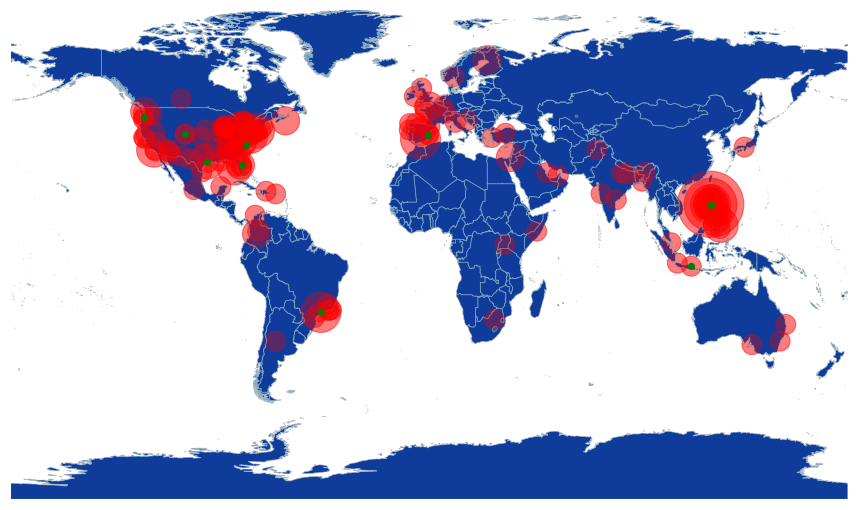

In [855]:
shp_link = './ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'
shp = ps.open(shp_link)
some = [True for i in ps.open(shp_link)] #bool(rdm.getrandbits(1))


fig = figure(figsize=(15,9))

base = maps.map_poly_shp(shp)
base.set_facecolor('navy')
base.set_linewidth(0.75)
base.set_edgecolor('0.8')
some = maps.map_poly_shp(shp, which=some)
some.set_alpha(0.5)
some.set_linewidth(0.)
ptsC = scatter(df1['centroid_lat'], df1['centroid_lon'], s=400*df1['count'], alpha=.3)
ptsC.set_color('red')

pts = scatter(coordinates['latitude'], coordinates['longitude'])
pts.set_color('green')

ax = maps.setup_ax([base, some, ptsC, pts], [shp.bbox, shp.bbox, shp.bbox, shp.bbox])

fig.add_axes(ax)
show()

# Thank you!

In [856]:
#df.to_csv('../dataTNASATalk.csv', index=False)

In [66]:
#dfA = pd.read_csv('dataT.csv')

In [70]:
def Converter(x):
    try:
        return eval(x)
    except:
        None

In [71]:
#dfA['raw_data'] = dfA.apply(lambda x: Converter(x['raw_data']), 1)

In [74]:
#L = list(dfA['raw_data']) + L

In [ ]:
#L = [x for x in L if x]